In [72]:
# auto reload notebooks with magic
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [73]:
import json
import numpy as np
import soundfile as sf
import librosa as lr
import pyroomacoustics as pra
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import scipy as sp
from scipy.io import wavfile


from tqdm import tqdm
from pathlib import Path

from pprint import pprint

from cacgmm.cacgmm_trainer import CACGMMTrainer

from mir_eval.separation import bss_eval_images

# Load data

In [74]:
path_to_data = Path('./datanet/projects/otohikari/robin/measurements/20171207/')
# load parameters from config file json
path_to_config = path_to_data / 'protocol.json'
with open(path_to_config) as json_file:
    config = json.load(json_file)

In [75]:
pprint(config)

{'conditions': {'humidity': 58.0, 'temperature': 22.0},
 'equipment': {'camera': 'Olympus Pen E-PL2',
               'microphones': ['Pyramic 48 MEMS microphone array, see '
                               'https://github.com/LCAV/Pyramic',
                               'Olympus ME51S'],
               'sound2light': ['First Raspberry Pi prototype'],
               'speakers': 'Bose Micro Music Monitor'},
 'geometry': {'microphones': {'olympus': {'comment': 'The two microphones were '
                                                     'placed horizontally with '
                                                     'respect to the floor, '
                                                     'with left/right matching '
                                                     'the orientation of the '
                                                     'camera. The microphones '
                                                     'were placed 25 cm to the '
                              

In [76]:
room_dim = config['geometry']['room']
mic_pos = np.array(config['geometry']['microphones']['pyramic']['locations']) 
ref_pos = np.array(config['geometry']['microphones']['pyramic']['reference'])
src_pos = np.array(config['geometry']['speakers']['locations']) # [noise, speech]

temperature = config['conditions']['temperature']
humidity = config['conditions']['humidity']

print('Room dimensions:', room_dim)
print('Microphones positions:', mic_pos.shape)
print('Array position:', ref_pos.shape)
print('Speakers positions:', src_pos.shape)

print(ref_pos)
print(src_pos)

Room dimensions: [8.945, 7.421, 2.6]
Microphones positions: (48, 3)
Array position: (3,)
Speakers positions: (2, 3)
[3.55  6.611 0.875]
[[5.695 4.22  0.85 ]
 [6.778 6.656 0.85 ]]


In [77]:
mic_idx = list(range(8, 16)) + list(range(24, 32)) + list(range(40, 48)) # flat part
mic_pos = mic_pos[mic_idx, :]

mic_pos -= np.mean(mic_pos, axis=0)[None, :]
mic_pos[:, 2] -= np.max(mic_pos[:, 2])
mic_pos += ref_pos
print(mic_pos.shape)

(24, 3)


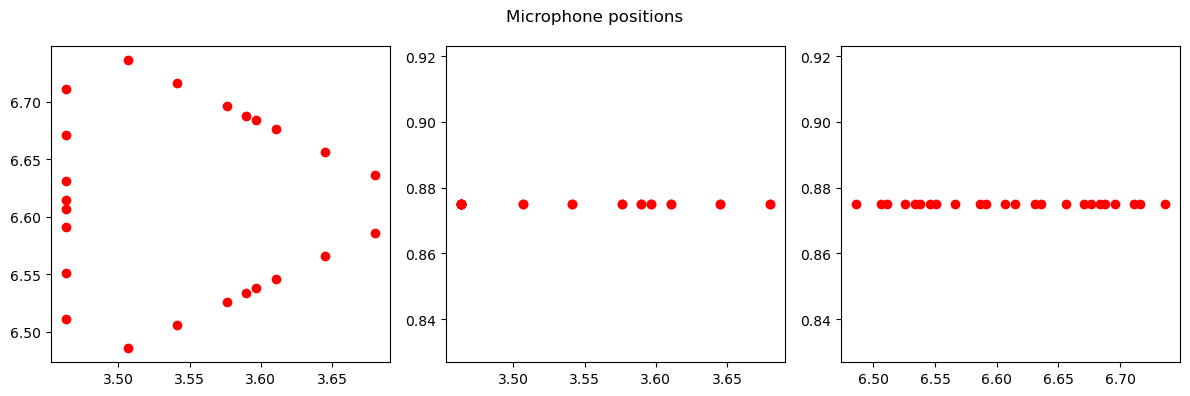

In [78]:
plt.figure(figsize=(12,4))
plt.suptitle('Microphone positions')
plt.subplot(1,3,1)
plt.scatter(mic_pos[:,0], mic_pos[:,1], c='r')
plt.subplot(1,3,2)
plt.scatter(mic_pos[:,0], mic_pos[:,2], c='r')
plt.subplot(1,3,3)
plt.scatter(mic_pos[:,1], mic_pos[:,2], c='r')
plt.tight_layout()
plt.show()

# Set parameters

In [79]:
# PARAMS
MIC = "pyramic_audio"
SIR = "5"
NFFT = 1024

vad_guard = 1024

In [80]:
# LOAD DATA
file_pattern = "segmented/{}_{}_SIR_{}_dB.wav"
file_speech_ref = "segmented/{}_speech_ref.wav"

mix, fs_mix = sf.read(path_to_data / file_pattern.format(MIC, "mix", SIR))
print('mix', mix.shape, fs_mix)
led, fs_led = sf.read(path_to_data / file_pattern.format("camera_leds_zero_hold", "mix", SIR))
assert fs_mix == fs_led
print('led', led.shape, fs_led)

noise_ref, fs_nse = sf.read(path_to_data / file_pattern.format(MIC, "noise_ref", SIR))
assert fs_mix == fs_nse
print('noise_ref', noise_ref.shape, fs_nse)
speech_ref, fs_src = sf.read(path_to_data / file_speech_ref.format(MIC))
assert fs_mix == fs_src
print('speech_ref', speech_ref.shape, fs_src)

fs = fs_mix


mix (287659, 48) 16000
led (287659,) 16000
noise_ref (287659, 48) 16000
speech_ref (287659, 48) 16000


In [81]:
# select mic index
mix = mix[:, mic_idx]
noise_ref = noise_ref[:, mic_idx]
speech_ref = speech_ref[:, mic_idx]

print('mix', mix.shape)
print('noise_ref', noise_ref.shape)
print('speech_ref', speech_ref.shape)

mix (287659, 24)
noise_ref (287659, 24)
speech_ref (287659, 24)


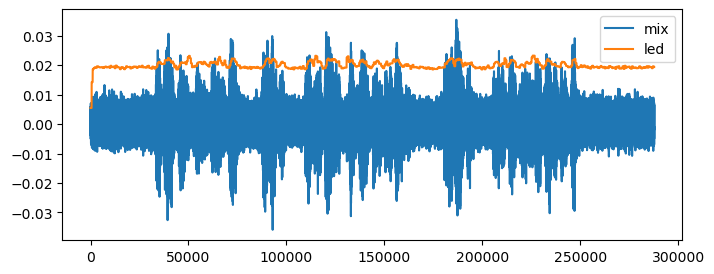

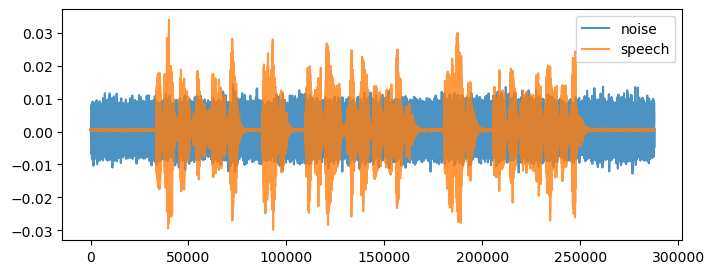

In [82]:
plt.figure(figsize=(8,3))
plt.plot(mix[:,0], label='mix')
plt.plot(led, label='led')
plt.legend()
plt.show()

plt.figure(figsize=(8,3))
plt.plot(noise_ref[:,0], label='noise', alpha=0.8)
plt.plot(speech_ref[:,0], label='speech', alpha=0.8)
plt.legend()
plt.show()

32767
32768


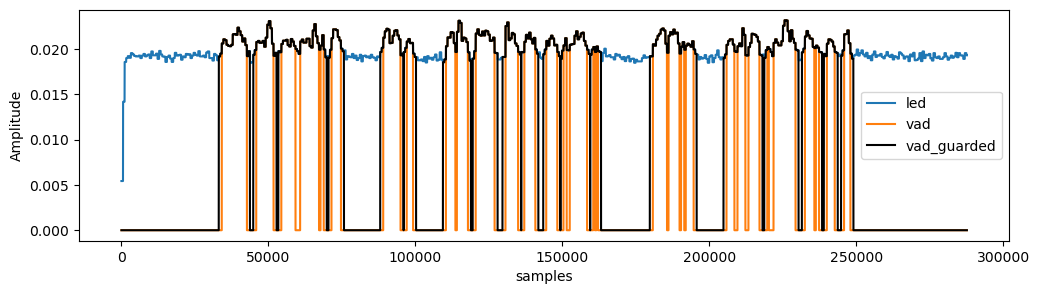

In [83]:
# process the VAD
# vad threshold are defined for the int16 format, as read by scipy.io.wavfile.read
vad_thresh = {"5": 660, "10": 600, "15": 540, "20": 450, "25": 340}  # 2017/12/07
fs, wav = wavfile.read(path_to_data / file_pattern.format(MIC, "mix", SIR))
intinfo = np.iinfo(wav.dtype)
print(intinfo.max)
print(-intinfo.min)

vad_snd = led > vad_thresh[SIR] / intinfo.max
 
plt.figure(figsize=(12,3))
plt.plot(led, label='led')
plt.plot(vad_snd * led, label='vad')

# Now we want to make sure no speech speech goes in estimation of the noise covariance matrix.
# For that we will remove frames neighbouring the detected speech
vad_guarded = vad_snd.copy()
if vad_guard is not None:
    for i, v in enumerate(vad_snd):
        if np.any(vad_snd[i - vad_guard : i + vad_guard]):
            vad_guarded[i] = True

plt.plot(vad_guarded * led, 'k', label='vad_guarded')
plt.xlabel('samples')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

vad = vad_guarded

# Create a PRA Room

In [84]:
rt60 = 0.3  # seconds
e_absorption, max_order = pra.inverse_sabine(rt60, room_dim)

print("absorption = ", e_absorption)
print("max_order = ", max_order)

room = pra.ShoeBox(room_dim, fs=fs, materials=pra.Material(e_absorption), max_order=max_order)
room.add_source(src_pos[0]) # speech
room.add_source(src_pos[1]) # noise
room.add_microphone_array(pra.MicrophoneArray(mic_pos.T, fs=room.fs))

# anechoic room, usefull fro computing anechoic images
aroom = pra.ShoeBox(room_dim, fs=fs, materials=pra.Material(e_absorption), max_order=0)
aroom.add_microphone_array(pra.MicrophoneArray(mic_pos.T, fs=room.fs))
aroom.add_source(src_pos[0]) # speech
aroom.add_source(src_pos[1]) # noise

absorption =  0.42544206985987926
max_order =  41


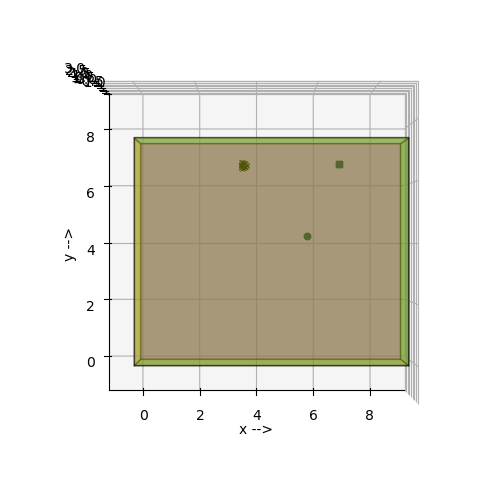

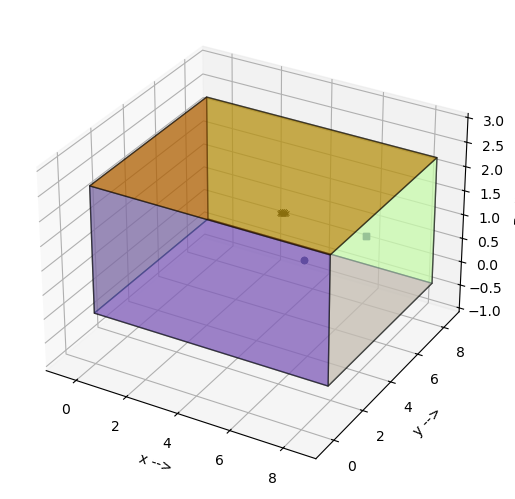

In [85]:
fig, ax = room.plot()
ax.set_xlim([-1, 9])
ax.set_ylim([-1, 9])
ax.set_zlim([-1, 3])
ax.set_xlabel("x -->")
ax.set_ylabel("y -->")
# top view
ax.view_init(elev=90, azim=-90)
plt.show()

fig, ax = room.plot()
ax.set_xlim([-1, 9])
ax.set_ylim([-1, 9])
ax.set_zlim([-1, 3])
ax.set_xlabel("x -->")
ax.set_ylabel("y -->")
ax.set_zlabel("z -->")
plt.show()

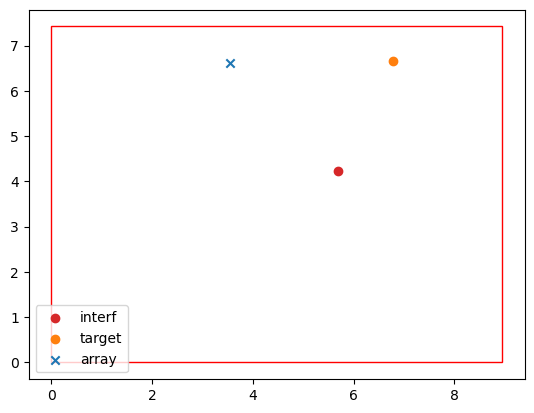

In [86]:
fig, ax = plt.subplots()

plt.scatter(src_pos[0,0], src_pos[0,1], c='C3', label='interf')
plt.scatter(src_pos[1,0], src_pos[1,1], c='C1', label='target')
plt.scatter(ref_pos[0], ref_pos[1], c='C0', marker='x', label='array')

rect = patches.Rectangle((0, 0), room_dim[0], room_dim[1], linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)
plt.legend(loc='lower left')
plt.show()

# Compute images and echoes parameters

In [87]:
room.compute_rir()
aroom.compute_rir()

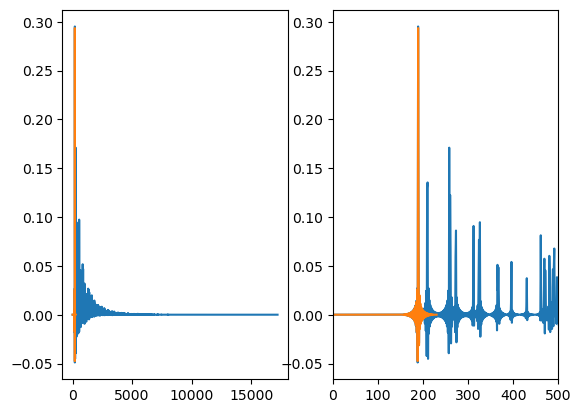

In [88]:
rirs = room.rir
arirs = aroom.rir

plt.subplot(1,2,1)
plt.plot(rirs[0][0])
plt.plot(arirs[0][0])
plt.subplot(1,2,2)
plt.plot(rirs[0][0])
plt.plot(arirs[0][0])
plt.xlim([0, 500])
plt.show()

In [89]:
doas = []
coeffs = []
toas = []
images = []

for s, source in enumerate(room.sources):
    
    src_images_pos =  room.sources[s].images
    src_images_order = room.sources[s].orders
    src_images_dampings = room.sources[s].damping
    src_images_dist = np.linalg.norm(src_images_pos - ref_pos[:,None], axis=0)

    # sort accoding to distance
    idx = np.argsort(src_images_dist)
        
    src_images_dist = src_images_dist[idx]
    src_images_pos = src_images_pos[:,idx]
    src_images_dampings = src_images_dampings[:,idx]
    
    # remove the images that are not on the x-y plane
    src_images_z = src_images_pos[2,:]
    idx = np.where(np.abs(src_images_z - src_images_z[0]) < 1e-6 )[0]
    
    src_images_dist = src_images_dist[idx]
    src_images_pos = src_images_pos[:,idx]
    src_images_dampings = src_images_dampings[:,idx]
    
    # keep first 100 accoding to distance    
    src_images_dist = src_images_dist[:100]
    src_images_pos = src_images_pos[:,:100]
    src_images_dampings = src_images_dampings[:,:100]

    # IMS VALUE
    coeffs.append(src_images_dampings.squeeze() / src_images_dist)

    # angle between image and reference point
    unit_vect = src_images_pos - ref_pos[:,None]
    doas_images = np.arctan2(unit_vect[1], unit_vect[0])
    doas_images = np.mod(doas_images, 2*np.pi)
    doas_gt = doas_images
    toas_gt = src_images_dist / room.c

    doas.append(doas_gt)
    toas.append(toas_gt)
    images.append(src_images_pos)

doas = np.array(doas)
toas = np.array(toas)
coeffs = np.array(coeffs)
images = np.array(images)

print('DOAS', doas.shape)
print('TOAS', toas.shape)
print('COEFFS', coeffs.shape)
print('IMAGES', images.shape)

DOAS (2, 100)
TOAS (2, 100)
COEFFS (2, 100)
IMAGES (2, 3, 100)


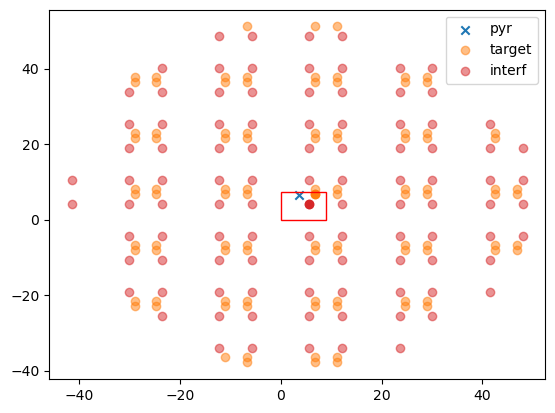

In [90]:
fig, ax = plt.subplots()

plt.scatter(ref_pos[0], ref_pos[1], c='C0', marker='x', label='pyr')

plt.scatter(src_pos[1,0], src_pos[1,1], c='C1')
plt.scatter(images[1][0], images[1][1], c='C1', alpha=0.5, label='target')

plt.scatter(src_pos[0,0], src_pos[0,1], c='C3')
plt.scatter(images[0][0], images[0][1], c='C3', alpha=0.5, label='interf')


rect = patches.Rectangle((0, 0), room_dim[0], room_dim[1], linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)

plt.legend()

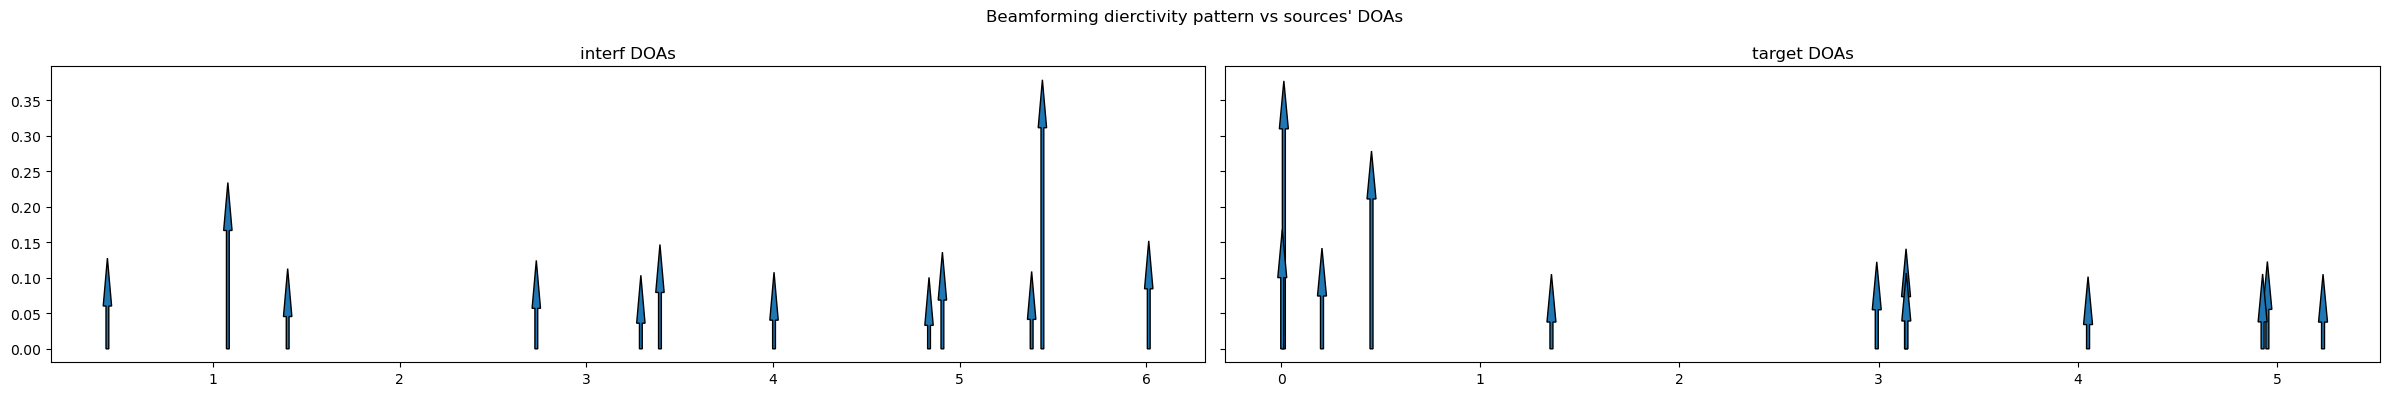

In [91]:
fig_pol, axarr = plt.subplots(1, 2, figsize=(24,4), sharey=True)
# fig_pol, axarr = plt.subplots(1, 2, figsize=(8,4), sharey=True, subplot_kw={'projection': 'polar'})

source_name = ['interf', 'target']

thr = 1 # degree

sources_doas_energy = {}

for src_idx in [0, 1]:

    doas_ = doas[src_idx]
    coeff_ = coeffs[src_idx]
    
    # sort the doas according to the energy
    idx = np.argsort(coeff_)[::-1]
    
    # prune the doas whose energy is below a threshold
    idx = idx[coeff_[idx] > 0.1 * coeff_[idx[0]]]
    doas_ = doas_[idx]
    coeff_ = coeff_[idx]
    
    # # energy per doa - integrate the energy on the same doa
    # unique_doas = np.unique(doas_)
    # unique_doas = np.sort(unique_doas)
    # unique_doas = unique_doas[np.where(np.diff(np.rad2deg(unique_doas)) > thr)]    
    # assert np.all(np.rad2deg(np.diff(unique_doas)) > thr)
    
    # energy_per_unique_doas = np.zeros_like(unique_doas)
    # for d, doa in enumerate(unique_doas):
    #     idx = np.where(np.abs(doas_ - doa) < np.deg2rad(thr))[0]
    #     # print(np.rad2deg(doa), idx)
    #     energy_per_unique_doas[d] = np.sum(np.abs(coeff_[idx]))
    
    # doas_ = unique_doas
    # coeff_ = energy_per_unique_doas
    
    sources_doas_energy[source_name[src_idx]] = (doas_, coeff_)

    # make a plot of the DOAS
    for d, (doa, coeff) in enumerate(zip(doas_, coeff_)):
        axarr[src_idx].arrow(doa, 0, 0, coeff, width = 0.015, edgecolor = 'black', facecolor = 'C0', lw = 1, zorder = 2)

    axarr[src_idx].set_title('{} DOAs'.format(source_name[src_idx]))


fig_pol.suptitle("Beamforming dierctivity pattern vs sources' DOAs")
fig_pol.tight_layout()
plt.show()

# STFT analysis

(24, 513, 562)


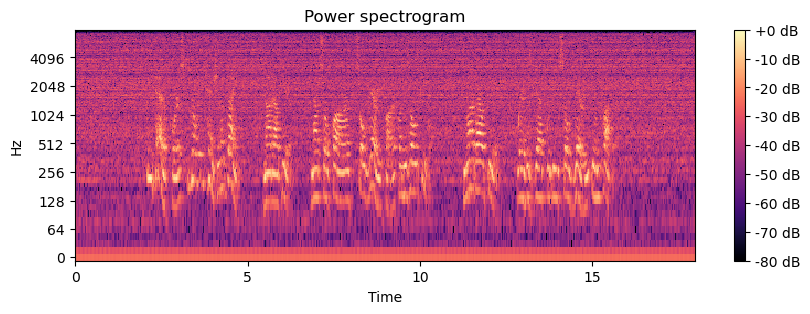

In [118]:
analysis = lambda x : lr.stft(x, n_fft=NFFT, hop_length=NFFT//2)

X = analysis(mix.T)
print(X.shape)

fig, ax = plt.subplots(figsize=(10, 3))
img = lr.display.specshow(lr.amplitude_to_db(np.abs(X[0,:]), ref=np.max), y_axis='log', x_axis='time', ax=ax, sr=fs)
ax.set_title('Power spectrogram')
fig.colorbar(img, ax=ax, format="%+2.0f dB")
plt.show()

X_s (24, 513, 562)


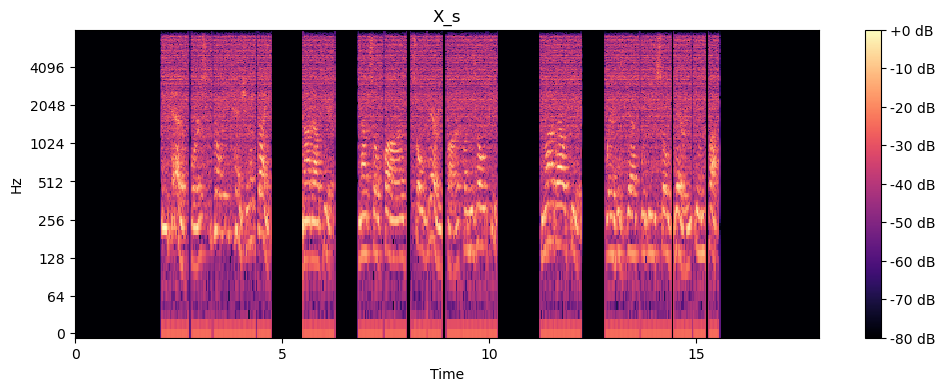

X_n (24, 513, 562)


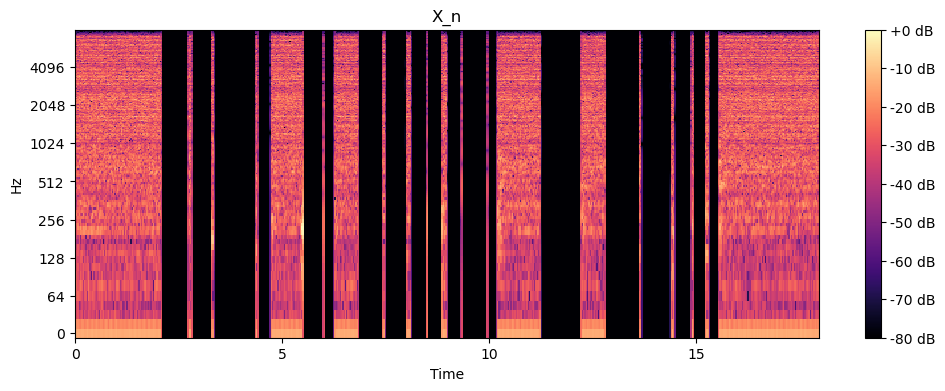

In [119]:
X_s = analysis(vad * mix.T)
print('X_s', X_s.shape)

fig, ax = plt.subplots(figsize=(12, 4))
img = lr.display.specshow(lr.amplitude_to_db(np.abs(X_s[0,:]), ref=np.max), y_axis='log', x_axis='time', ax=ax, sr=fs)
ax.set_title('X_s')
fig.colorbar(img, ax=ax, format="%+2.0f dB")
plt.show()

X_n = analysis((1-vad) * mix.T)
print('X_n', X_n.shape)

fig, ax = plt.subplots(figsize=(12, 4))
img = lr.display.specshow(lr.amplitude_to_db(np.abs(X_n[0,:]), ref=np.max), y_axis='log', x_axis='time', ax=ax, sr=fs)
ax.set_title('X_n')
fig.colorbar(img, ax=ax, format="%+2.0f dB")
plt.show()



# fig, ax = plt.subplots(figsize=(10, 3))
# img = lr.display.specshow(np.abs(VAD), y_axis='log', x_axis='time', ax=ax, sr=fs)
# ax.set_title('VAD')
# fig.colorbar(img, ax=ax, format="%+2.0f dB")
# plt.show()

In [125]:
nChan, nFreq, nTime = X_s.shape
X_s_ = X_s.transpose(2,1,0)
X_n_ = X_n.transpose(2,1,0)


Rs = np.einsum("i...j,i...k->...jk", X_s_, np.conj(X_s_)) / X_s_.shape[-1]
Rn = np.einsum("i...j,i...k->...jk", X_n_, np.conj(X_n_)) / X_n_.shape[-1]

# Rs = Rs - Rn

print('Rs', Rs.shape)
print('Rn', Rn.shape)

def max_sinr_weights_per_freq(Rs, Rn, n_channels):
    return sp.linalg.eigh(Rs, b=Rn, eigvals=(n_channels - 1, n_channels - 1),)[1]

w = [max_sinr_weights_per_freq(Rs[f], Rn[f], n_channels=nChan) for f in range(1,nFreq)]
w = np.squeeze(np.array(w))
print(w.shape)

# postprocess the weights
nw = sp.linalg.norm(w, axis=1)
w[nw > 1e-10, :] /= nw[nw > 1e-10, None]

w = np.concatenate([np.zeros((1, nChan)), w], axis=0)

Rs (513, 24, 24)
Rn (513, 24, 24)
(512, 24)


In [126]:
from max_sinr_beamforming import compute_gain
print(X_s_.shape)
print(w.shape)
z = compute_gain(w, X_s_, X_s_[:, :, 0])
w *= z[:, None]

w_maxsir = w

(562, 513, 24)
(513, 24)


In [127]:
# create the steering vectors for the mic array
theta = np.deg2rad(np.arange(-180, 180, 1))
vect_doa_src = np.stack([np.cos(theta), np.sin(theta), np.zeros_like(theta)])
print(vect_doa_src.shape)

vect_mics = mic_pos
print(vect_mics.shape)

toas_far_free = vect_doa_src.T @ vect_mics.T / room.c # nDoas x nChan
freqs = np.fft.rfftfreq((nFreq-1)*2, 1/fs)

svects = np.exp(- 1j * 2 * np.pi * freqs[:,None,None] * (toas_far_free[None,...])) #  nFreq x nDoas x nChan
print(svects.shape)

(3, 360)
(24, 3)
(513, 360, 24)


In [128]:
print(svects.shape)
print(w.shape)

bf_freq = np.abs(np.einsum('fm,fsm->fs', w, svects))**2
# mean over freqs
bf = np.mean(bf_freq, 0)
# normalize
bf = bf / np.max(np.abs(bf))

(513, 360, 24)
(513, 24)


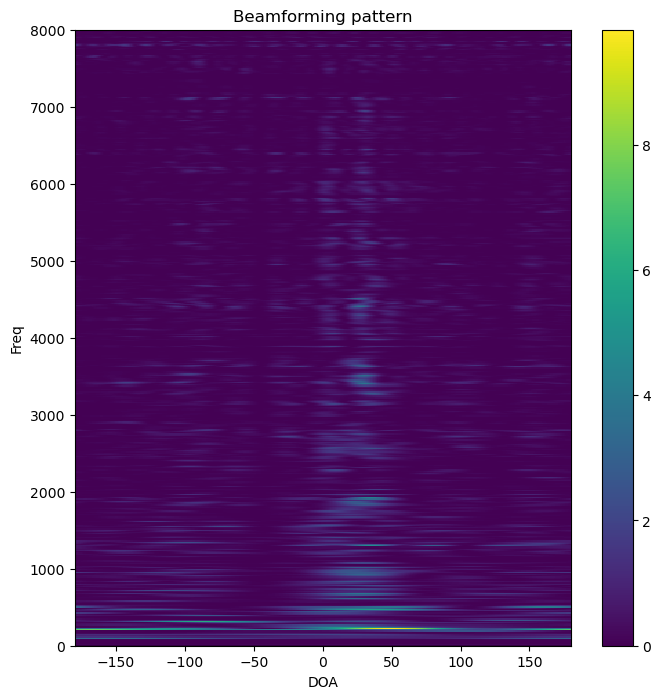

In [129]:
plt.figure(figsize=(8,8))
plt.title('Beamforming pattern')
plt.imshow(bf_freq, aspect='auto', origin='lower', interpolation='nearest', extent=[-180, 180, freqs[0], freqs[-1]])
plt.axhline(0, color='black', lw=1)
plt.colorbar()
plt.xlabel('DOA')
plt.ylabel('Freq')
plt.show()

IndexError: invalid index to scalar variable.

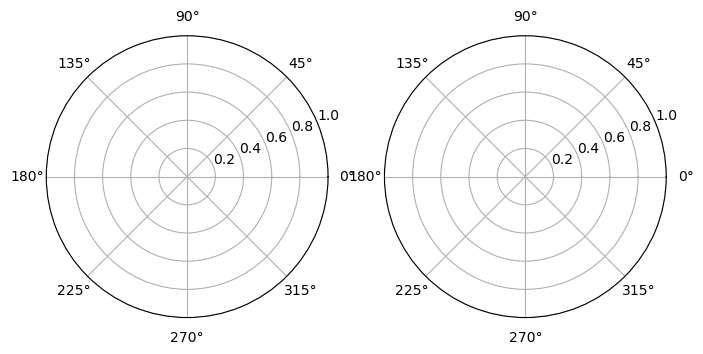

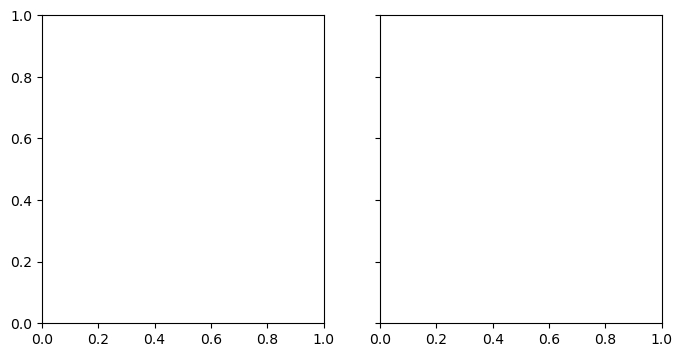

In [130]:
fig_pol, axarr_pol = plt.subplots(1, 2, figsize=(8,4), sharey=True, subplot_kw={'projection': 'polar'})
fig_lin, axarr_lin = plt.subplots(1, 2, figsize=(8,4), sharey=True)

source_name = ['interf', 'target']

for src_idx in [0, 1]:

    doas_ = doas[src_idx]
    coeff_ = coeffs[src_idx]
    coeff_ = coeff_ / np.max(coeff_)
    
    R = 20
    doas_ = doas_[:R]
    coeff_ = coeff_[:R]

    # polar plot

    axarr_pol[src_idx].plot(theta, bf, label='BF')
    axarr_lin[src_idx].plot(theta, bf, label='BF')
    for d, (doa, coeff) in enumerate(zip(doas_, coeff_)):
        axarr_pol[src_idx].arrow(doa, 0, 0, coeff, width = 0.015, edgecolor = 'black', facecolor = 'C0', lw = 1, zorder = 5)
        # add text on the tip of the arrow
        axarr_lin[src_idx].arrow(doa, 0, 0, coeff, width = 0.015, edgecolor = 'black', facecolor = 'C0', lw = 1, zorder = 5)
        axarr_lin[src_idx].text(doa, coeff + 0.1, f"{d}", fontsize=8, ha='center', va='center')

    axarr_lin[src_idx].set_title('{} DOAs'.format(source_name[src_idx]))
    axarr_pol[src_idx].set_title('{} DOAs'.format(source_name[src_idx]))


fig_pol.suptitle("Beamforming dierctivity pattern vs sources' DOAs")
fig_lin.suptitle("Beamforming dierctivity pattern vs sources' DOAs")
fig_lin.legend()
fig_pol.legend()
fig_lin.tight_layout()
fig_pol.tight_layout()
plt.show()

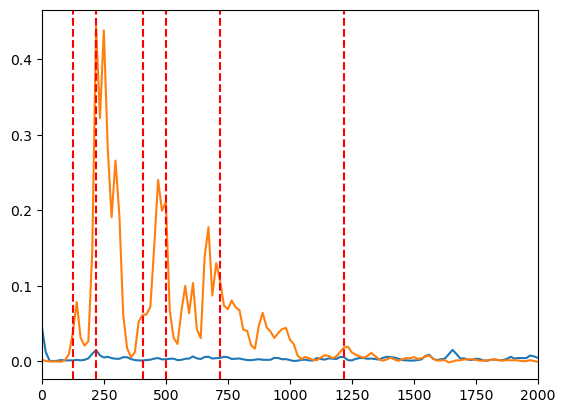

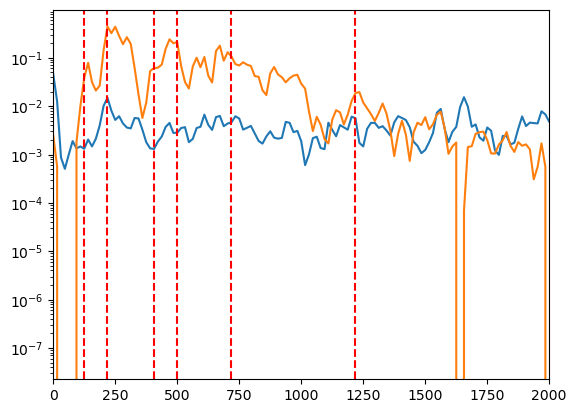

In [117]:
X_n_freq = np.sum(np.abs(X_n[0])**2, axis=-1).T / np.sum(np.mean(X_n[0], 0) > 1e-6)
X_s_freq = np.sum(np.abs(X_s[0])**2, axis=-1).T / np.sum(np.mean(X_s[0], 0) > 1e-6)

max_val = np.max([X_n_freq, X_s_freq])

plt.plot(freqs, X_n_freq)
plt.plot(freqs, X_s_freq - X_n_freq)

# freqs_to_plot = [125, 250, 375, 500, 750, 1250]
freqs_to_plot = [125.0, 218.75, 406.25, 500.0, 718.75, 1218.75]

# freqs_to_plot = [50, 125, 250, 500, 1000]
for freq in freqs_to_plot:
    plt.axvline(x=freq, color='r', linestyle='--')
plt.xlim([0, 2000])
plt.show()

# for f, freq in enumerate(freqs_to_plot):
#     freq_idx = np.argmin(np.abs(freqs - freq))
#     print(freq_idx)
#     print(freqs[freq_idx])
#     freqs_to_plot[f] = freqs[np.argmax(X_s_freq[freq_idx-3:freq_idx+3]) + freq_idx-3]
# print(freqs_to_plot)

plt.semilogy(freqs, X_n_freq)
plt.semilogy(freqs, X_s_freq - X_n_freq)
for freq in freqs_to_plot:
    plt.axvline(x=freq, color='r', linestyle='--')
plt.xlim([0, 2000])
plt.show()


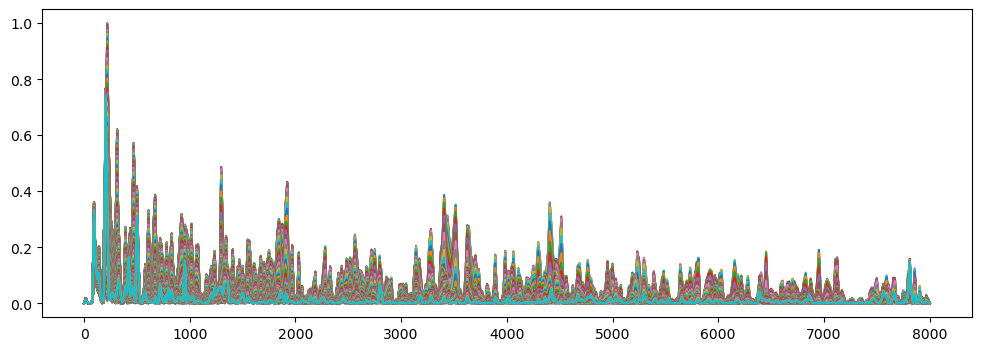

In [101]:
bf_freq_normalized = bf_freq / np.max(np.abs(bf_freq[10:,:]))

plt.figure(figsize=(12, 4))
plt.plot(freqs, np.abs(bf_freq_normalized))
plt.show()

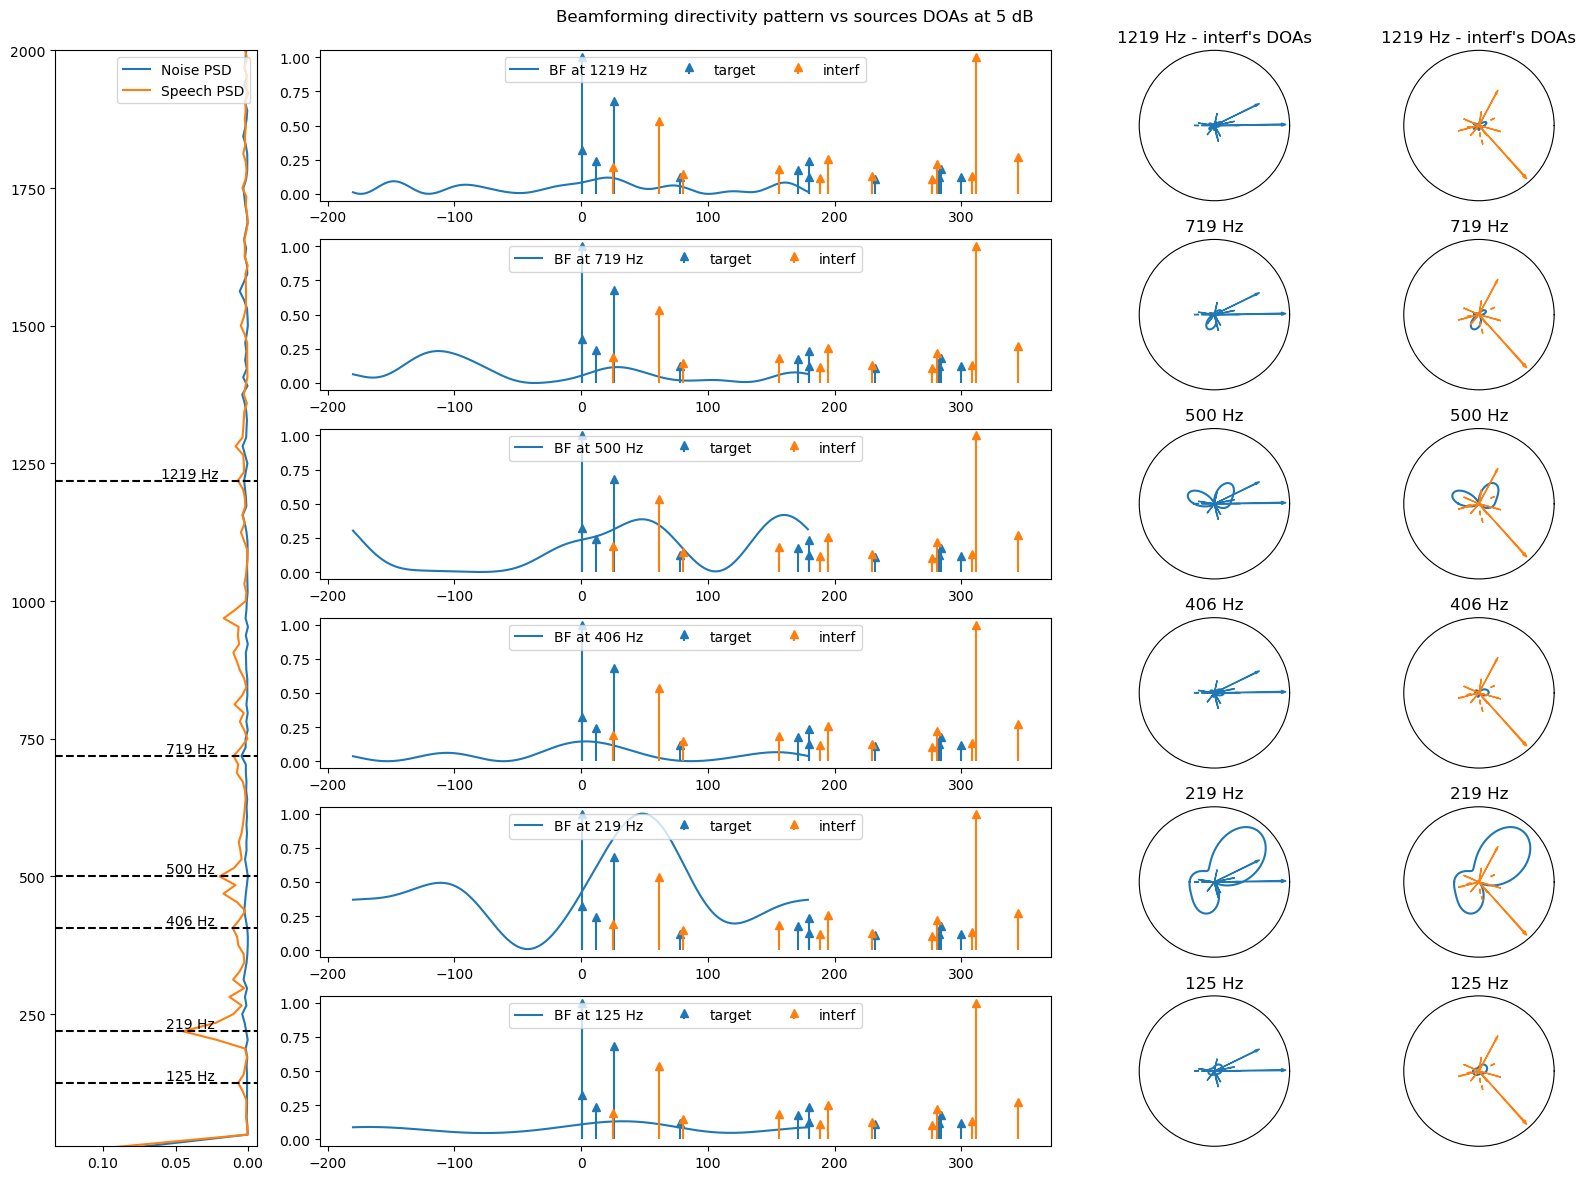

In [102]:
def generate_axes(fig):
    gridspec = fig.add_gridspec(nrows=24, ncols=12)
    axes = {}
    axes['spec'] = fig.add_subplot(gridspec[0:24, 0:2])
    
    axes['lin_doas6'] = fig.add_subplot(gridspec[0:4, 2:8])
    axes['pol_doas6'] = fig.add_subplot(gridspec[0:4, 8:10], projection='polar')
    axes['pol_doas6b'] = fig.add_subplot(gridspec[0:4, 10:12], projection='polar')
    axes['lin_doas5'] = fig.add_subplot(gridspec[4:8, 2:8])
    axes['pol_doas5'] = fig.add_subplot(gridspec[4:8, 8:10], projection='polar')
    axes['pol_doas5b'] = fig.add_subplot(gridspec[4:8, 10:12], projection='polar')
    axes['lin_doas4'] = fig.add_subplot(gridspec[8:12, 2:8])
    axes['pol_doas4'] = fig.add_subplot(gridspec[8:12, 8:10], projection='polar')
    axes['pol_doas4b'] = fig.add_subplot(gridspec[8:12, 10:12], projection='polar')
    axes['lin_doas3'] = fig.add_subplot(gridspec[12:16, 2:8])
    axes['pol_doas3'] = fig.add_subplot(gridspec[12:16, 8:10], projection='polar')
    axes['pol_doas3b'] = fig.add_subplot(gridspec[12:16, 10:12], projection='polar')
    axes['lin_doas2'] = fig.add_subplot(gridspec[16:20, 2:8])
    axes['pol_doas2'] = fig.add_subplot(gridspec[16:20, 8:10], projection='polar')
    axes['pol_doas2b'] = fig.add_subplot(gridspec[16:20, 10:12], projection='polar')
    axes['lin_doas1'] = fig.add_subplot(gridspec[20:24, 2:8])
    axes['pol_doas1'] = fig.add_subplot(gridspec[20:24, 8:10], projection='polar')
    axes['pol_doas1b'] = fig.add_subplot(gridspec[20:24, 10:12], projection='polar')
    return axes

fig = plt.figure(figsize=(16, 12))
axes = generate_axes(fig)
axes['spec'].plot(X_n_freq, freqs, label='Noise PSD')
axes['spec'].plot(X_s_freq, freqs, label='Speech PSD')
axes['spec'].invert_xaxis()
axes['spec'].set_ylim([10, 2000])
axes['spec'].legend(loc="upper right")


for f, freq in enumerate(freqs_to_plot):
    freq_idx = np.argmin(np.abs(freqs - freq))
    curr_bf = bf_freq_normalized[freq_idx]
    axes[f'lin_doas{f+1}'].plot(np.rad2deg(theta), curr_bf, label=f'BF at {freq:.0f} Hz')
    
    axes[f'pol_doas{f+1}'].plot(theta, curr_bf, label=f'{freq:.0f} Hz')
    axes[f'pol_doas{f+1}b'].plot(theta, curr_bf, label=f'{freq:.0f} Hz')
    
    axes[f'pol_doas{f+1}'].set_xticks([])
    axes[f'pol_doas{f+1}'].set_yticks([])
    axes[f'pol_doas{f+1}b'].set_xticks([])
    axes[f'pol_doas{f+1}b'].set_yticks([])
    
    for src_name, color, plot in zip(['target', 'interf'], ['C0', 'C1'], ['', 'b']):
        doas_, coeff_ = sources_doas_energy[src_name]
        coeff_ = coeff_  / np.max(coeff_)
        for i, (doa, coeff) in enumerate(zip(doas_, coeff_)):
            if i == 0:
                axes[f'pol_doas{f+1}{plot}'].arrow(doa, 0, 0, coeff, width = 0.015, edgecolor = color, facecolor = color, lw = 1, zorder = 5, label=src_name)
            else:
                axes[f'pol_doas{f+1}{plot}'].arrow(doa, 0, 0, coeff, width = 0.015, edgecolor = color, facecolor = color, lw = 1, zorder = 5)
        
        axes[f'lin_doas{f+1}'].stem(np.rad2deg(doas_), coeff_, 
                                    markerfmt=f'{color}^', 
                                    linefmt=f'{color}',
                                    basefmt=' ', label=src_name)
                
    axes[f'lin_doas{f+1}'].legend(loc='upper center', ncols=3)
    
    if f == len(freqs_to_plot) - 1:
        axes[f'pol_doas{f+1}'].set_title(f"{freq:.0f} Hz - target's DOAs")
        axes[f'pol_doas{f+1}b'].set_title(f"{freq:.0f} Hz - interf's DOAs")
    else:
        axes[f'pol_doas{f+1}'].set_title(f"{freq:.0f} Hz")
        axes[f'pol_doas{f+1}b'].set_title(f"{freq:.0f} Hz")
    
    axes['spec'].axhline(freq, color='k', linestyle='--')
    axes['spec'].text(0.04, freq, f"{freq:.0f} Hz", ha='center', va='bottom')

axes[f'pol_doas6'].set_title(f"{freq:.0f} Hz - {src_name}'s DOAs")
axes[f'pol_doas6b'].set_title(f"{freq:.0f} Hz - {src_name}'s DOAs")

plt.suptitle(f'Beamforming directivity pattern vs sources DOAs at {SIR} dB')
plt.tight_layout()
plt.savefig(f'figures/beamforming_sir-{SIR}.png')

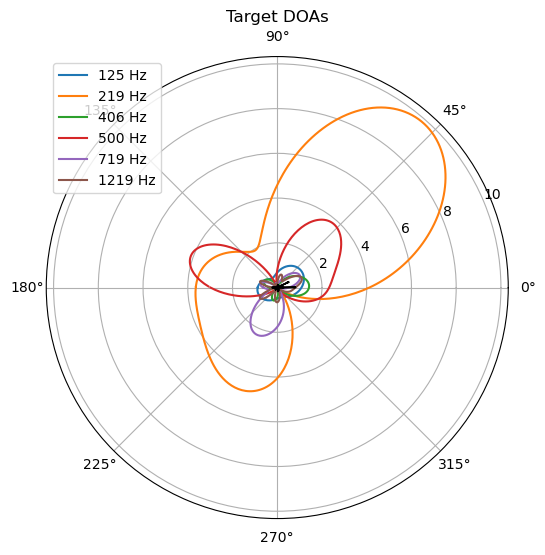

In [103]:
plt.figure(figsize=(6,6))
plt.subplot(111, polar=True)
plt.title('Target DOAs')

# freqs_to_plot = [100, 300, 500, 1000]
idx_freqs = [np.argmin(np.abs(f - freqs)) for f in freqs_to_plot]

for f in idx_freqs:
    plt.plot(theta, bf_freq[f], label=f'{freqs[f]:.0f} Hz')
plt.legend()

doas_, coeff_ = sources_doas_energy['target']
for doa, coeff in zip(doas_, coeff_):
    plt.arrow(doa, 0, 0, 2.5*coeff, width = 0.015, edgecolor = 'black', facecolor = 'C0', lw = 1.2, zorder = 5)
plt.show()

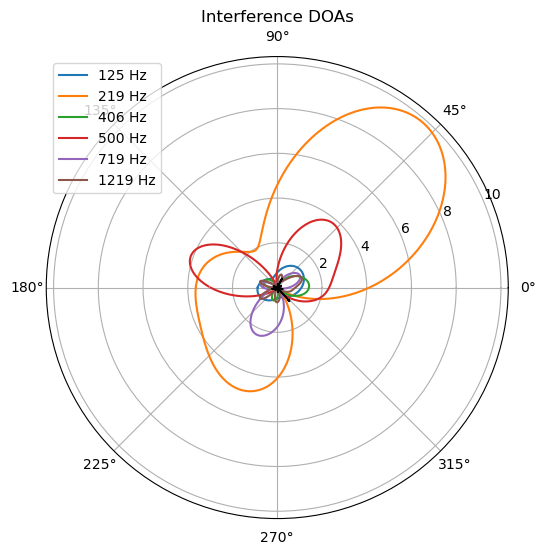

In [104]:
plt.figure(figsize=(6,6))
plt.subplot(111, polar=True)
plt.title('Interference DOAs')

# freqs_to_plot = [100, 300, 500, 1000]
idx_freqs = [np.argmin(np.abs(f - freqs)) for f in freqs_to_plot]

for f in idx_freqs:
    plt.plot(theta, bf_freq[f], label=f'{freqs[f]:.0f} Hz')
plt.legend()

doas_, coeff_ = sources_doas_energy['interf']
for doa, coeff in zip(doas_, coeff_):
    plt.arrow(doa, 0, 0, 2.5*coeff, width = 0.015, edgecolor = 'black', facecolor = 'C0', lw = 1.2, zorder = 2)
plt.show()

# Metrics

In [105]:
doas_src, coeff_src = sources_doas_energy['target']

idx = np.argsort(coeff_src)[::-1][:5]
doas_src = doas_src[idx]
coeff_src = coeff_src[idx]

doas_int, coeff_int = sources_doas_energy['interf']
idx = np.argsort(coeff_int)[::-1][:5]
doas_int = doas_int[idx]
coeff_int = coeff_int[idx]

/var/folders/6j/jjy0khhn7n57n5dmw92shzg80000gn/T/ipykernel_10258/996564306.py:11: RuntimeWarning: invalid value encountered in divide
  bf_freq = np.abs(np.einsum('fm,fsm->fs', w, svects))**2 / (np.linalg.norm(w, axis=1)[:,None] * np.linalg.norm(svects, axis=2))


(513, 5)
[  0.  26.   0.  11. 179.]


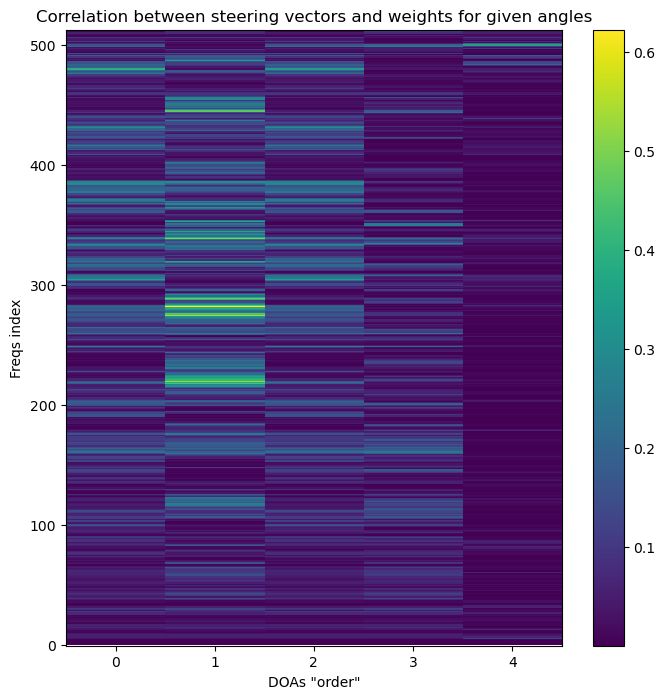

In [106]:
# correlation between steering vectors and weights
vect_doa_src = np.stack([np.cos(doas_src), np.sin(doas_src), np.zeros_like(doas_src)])

vect_mics = mic_pos

toas_far_free = vect_doa_src.T @ vect_mics.T / room.c # nDoas x nChan
freqs = np.fft.rfftfreq((nFreq-1)*2, 1/fs)

svects = np.exp(- 1j * 2 * np.pi * freqs[:,None,None] * (toas_far_free[None,...])) #  nFreq x nDoas x nChan

bf_freq = np.abs(np.einsum('fm,fsm->fs', w, svects))**2 / (np.linalg.norm(w, axis=1)[:,None] * np.linalg.norm(svects, axis=2))

print(bf_freq.shape)

print(np.floor(np.rad2deg(doas_src)))

plt.figure(figsize=(8,8))
plt.imshow(bf_freq, aspect='auto', origin='lower', interpolation='nearest')
plt.colorbar()
plt.xlabel('DOAs "order"')
# plt.gca().set_xticklabexls([f"{doa} asd" for doa in np.floor(np.rad2deg(doas_src))])
plt.ylabel('Freqs index')
plt.title('Correlation between steering vectors and weights for given angles')
plt.show()

/var/folders/6j/jjy0khhn7n57n5dmw92shzg80000gn/T/ipykernel_10258/4248078357.py:11: RuntimeWarning: invalid value encountered in divide
  bf_freq = np.abs(np.einsum('fm,fsm->fs', w, svects))**2 / (np.linalg.norm(w, axis=1)[:,None] * np.linalg.norm(svects, axis=2))


(513, 5)


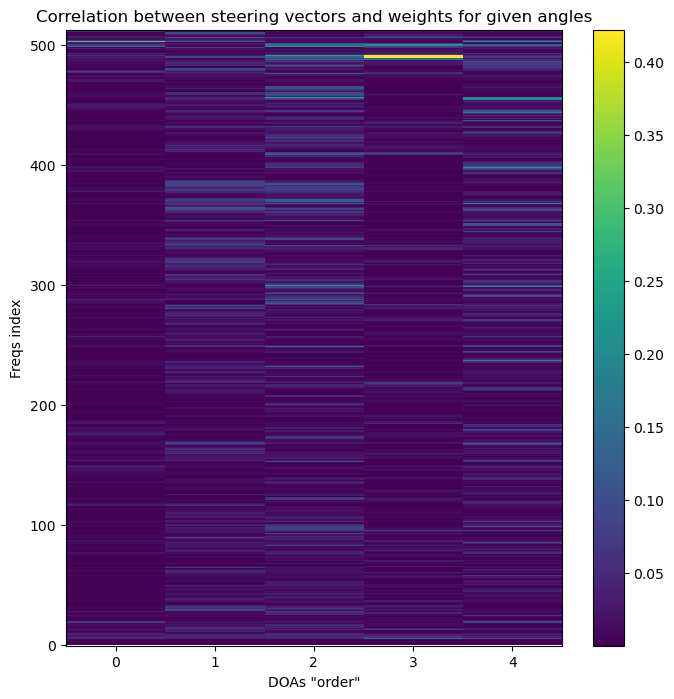

In [107]:
# correlation between steering vectors and weights
vect_doa_int = np.stack([np.cos(doas_int), np.sin(doas_int), np.zeros_like(doas_int)])

vect_mics = mic_pos

toas_far_free = vect_doa_int.T @ vect_mics.T / room.c # nDoas x nChan
freqs = np.fft.rfftfreq((nFreq-1)*2, 1/fs)

svects = np.exp(- 1j * 2 * np.pi * freqs[:,None,None] * (toas_far_free[None,...])) #  nFreq x nDoas x nChan

bf_freq = np.abs(np.einsum('fm,fsm->fs', w, svects))**2 / (np.linalg.norm(w, axis=1)[:,None] * np.linalg.norm(svects, axis=2))

print(bf_freq.shape)

plt.figure(figsize=(8,8))
plt.imshow(bf_freq, aspect='auto', origin='lower', interpolation='nearest')
plt.colorbar()
plt.xlabel('DOAs "order"')
# plt.gca().set_xticklabexls([f"{doa} asd" for doa in np.floor(np.rad2deg(doas_src))])
plt.ylabel('Freqs index')
plt.title('Correlation between steering vectors and weights for given angles')
plt.show()

# Beamforming

In [108]:
# Signal alignment step
ref = np.vstack([speech_ref[:, 0], noise_ref[:, 0]])

print(ref.shape)
print(mix.shape)
ref_mic = 0

metric = bss_eval_images(
    ref[:, :, None], 
    np.stack([mix.T[ref_mic,:, None]]*2, axis=0))
SDR_in = metric[0][0]
SIR_in = metric[2][0]
print('SDR_in', SDR_in)
print('SIR_in', SIR_in)

(2, 287659)
(287659, 24)
SDR_in -3.9925310827520426
SIR_in 5.595138840349634


## MaxSIR

In [109]:
nfft = 1024
mic_array = pra.Beamformer(
    mic_pos[:, :2].T, fs=fs_mix, N=nfft, hop=nfft, zpb=nfft
)
mic_array.signals = mix.T
mic_array.weights = w.T

out = mic_array.process()

# Not sure why the delay is sometimes negative here... Need to check more
delay = np.abs(int(pra.tdoa(out, speech_ref[:, 0].astype(float), phat=True)))
if delay > 0:
    out_trunc = out[delay : delay + ref.shape[1]]
    noise_eval = mix[: ref.shape[1], 0] - out_trunc
else:
    out_trunc = np.concatenate((np.zeros(-delay), out[: ref.shape[1] + delay]))
    noise_eval = mix[: ref.shape[1], 0] - out_trunc
sig_eval = np.vstack([out_trunc, noise_eval])

# We use the BSS eval toolbox
metric = bss_eval_images(ref[:, :, None], sig_eval[:, :, None])

# we are only interested in SDR and SIR for the speech source
SDR_out = metric[0][0]
SIR_out = metric[2][0]

iSDR = SDR_out - SDR_in
iSIR = SIR_out - SIR_in

print(f"SDR: {SDR_out:.2f} dB --> {iSDR:.2f} imp")
print(f"SIR: {SIR_out:.2f} dB --> {iSIR:.2f} imp")

SDR: 6.30 dB --> 10.29 imp
SIR: 27.08 dB --> 21.48 imp


## DS beamformer

In [110]:
doas, coeff = sources_doas_energy['target']
doa = np.rad2deg(doas_src[0])

def delay_and_sum(doa, mic_pos, c, freqs):
    vect_to_src = np.array([[np.cos(doa), np.sin(doa)]]).T
    toas_far_free = mic_pos[:,:2] @ vect_to_src / c
    # compute steeering vectors
    a = np.exp(- 1j * 2 * np.pi * freqs[:,None] * toas_far_free[None,:,0])
    # compute optimal weights
    w = np.conj(a) / np.sum(np.abs(a)**2, axis=0)
    return w

w = delay_and_sum(doas_src[0], mic_pos, room.c, freqs)
z = compute_gain(w, X_s_, X_s_[:, :, 0])
w *= z[:, None]

nfft = 1024
mic_array = pra.Beamformer(
    mic_pos[:, :2].T, fs=fs_mix, N=nfft, hop=nfft, zpb=nfft
)
mic_array.signals = mix.T
mic_array.weights = w.T

out = mic_array.process()

# check the delay
delay = np.abs(int(pra.tdoa(out, speech_ref[:, 0].astype(float), phat=True)))
if delay > 0:
    out_trunc = out[delay : delay + ref.shape[1]]
    noise_eval = mix[: ref.shape[1], 0] - out_trunc
else:
    out_trunc = np.concatenate((np.zeros(-delay), out[: ref.shape[1] + delay]))
    noise_eval = mix[: ref.shape[1], 0] - out_trunc
sig_eval = np.vstack([out_trunc, noise_eval])

# We use the BSS eval toolbox
metric = bss_eval_images(ref[:, :, None], sig_eval[:, :, None])

# we are only interested in SDR and SIR for the speech source
SDR_out = metric[0][0]
SIR_out = metric[2][0]

iSDR = SDR_out - SDR_in
iSIR = SIR_out - SIR_in

print(f"SDR: {SDR_out:.2f} dB --> {iSDR:.2f} imp")
print(f"SIR: {SIR_out:.2f} dB --> {iSIR:.2f} imp")

SDR: 5.73 dB --> 9.72 imp
SIR: 8.41 dB --> 2.82 imp


## MVDR

In [111]:
doas, coeff = sources_doas_energy['target']
doa = np.rad2deg(doas_src[0])

def mvdr(doa, mic_pos, c, freqs, Rn):
    vect_to_src = np.array([[np.cos(doa), np.sin(doa)]]).T
    toas_far_free = mic_pos[:,:2] @ vect_to_src / c
    # compute steeering vectors
    a = np.exp(- 1j * 2 * np.pi * freqs[:,None] * toas_far_free[None,:,0])
    # compute optimal weights
    invRn = np.linalg.inv(Rn)
    aH_invRn = np.einsum("fi,fij->fi", np.conj(a), invRn)
    aH_invRn_a = np.einsum("fi,fi->f", aH_invRn, a)
    w = aH_invRn / aH_invRn_a[:, None]
    return w

Rn = np.einsum("i...j,i...k->...jk", X_n_, np.conj(X_n_)) / X_n_.shape[-1]
print(Rn.shape)

w = mvdr(doas_src[0], mic_pos, room.c, freqs, Rn)
z = compute_gain(w, X_s_, X_s_[:, :, 0])
w *= z[:, None]

nfft = 1024
mic_array = pra.Beamformer(
    mic_pos[:, :2].T, fs=fs_mix, N=nfft, hop=nfft, zpb=nfft
)
mic_array.signals = mix.T
mic_array.weights = w.T

out = mic_array.process()

# check the delay
delay = np.abs(int(pra.tdoa(out, speech_ref[:, 0].astype(float), phat=True)))
if delay > 0:
    out_trunc = out[delay : delay + ref.shape[1]]
    noise_eval = mix[: ref.shape[1], 0] - out_trunc
else:
    out_trunc = np.concatenate((np.zeros(-delay), out[: ref.shape[1] + delay]))
    noise_eval = mix[: ref.shape[1], 0] - out_trunc
sig_eval = np.vstack([out_trunc, noise_eval])

# We use the BSS eval toolbox
metric = bss_eval_images(ref[:, :, None], sig_eval[:, :, None])

# we are only interested in SDR and SIR for the speech source
SDR_out = metric[0][0]
SIR_out = metric[2][0]

iSDR = SDR_out - SDR_in
iSIR = SIR_out - SIR_in

print(f"SDR: {SDR_out:.2f} dB --> {iSDR:.2f} imp")
print(f"SIR: {SIR_out:.2f} dB --> {iSIR:.2f} imp")

(513, 24, 24)
SDR: -6.05 dB --> -2.06 imp
SIR: 5.18 dB --> -0.42 imp


## CACGMM

Complex angular GMM model for mask estimation

In [112]:
# source_activity = np.random.rand(2, 1000)
# source_activity = source_activity / np.sum(source_activity, axis=0)
# source_activity = source_activity > 0

# initialization = np.repeat(source_activity[None, ...], 513, axis=0)     # F x K x T
# source_active_mask = np.repeat(source_activity[None, ...], 513, axis=0) # F x K x T
# X = np.random.rand(4, 1000, 513) + 1j * np.random.rand(4, 1000, 513)    # D x T x F

# print(X.shape)
# print(source_active_mask.shape)
# print(initialization.shape)

# X = analysis(mix.T)             # C x F x T
# A1 = analysis(vad * 1.)             # F x T
# A2 = analysis((~ vad) * 1.)         # F x T
# A = np.stack([A1, A2], axis=0)  # K x F x T
# S1 = analysis(vad * mix[...,0])     # F x T
# S2 = analysis((~ vad) * mix[...,0]) # F x T
# S = np.stack([S1, S2], axis=0)  # K x F x T

# X = X.transpose(1, 2, 0) # C x F x T --> C x T x F
# A = A.transpose(1, 0, 2) # K x F x T --> F x T x K
# S = S.transpose(1, 0, 2) # K x F x T --> F x T x K
# A = np.abs(A) > 0.1

# cacGMM = CACGMMTrainer()

# print(X.shape)
# print(A.shape)
# print(S.shape)

# cur = cacGMM.fit(
#     y=X,                    # F x T x C
#     initialization=S,       # F x K x T
#     iterations=10,
#     source_activity_mask=A, # F x K x T
# )

# affiliation = cur.predict(X.T, source_activity_mask=A) # 
# posterior = affiliation.transpose(1, 2, 0)  # K x T x F

In [113]:
doas, coeff = sources_doas_energy['target']
doa = np.rad2deg(doas_src[0])

def mvdr(doa, mic_pos, c, freqs, Rn):
    vect_to_src = np.array([[np.cos(doa), np.sin(doa)]]).T
    toas_far_free = mic_pos[:,:2] @ vect_to_src / c
    # compute steeering vectors
    a = np.exp(- 1j * 2 * np.pi * freqs[:,None] * toas_far_free[None,:,0])
    # compute optimal weights
    invRn = np.linalg.inv(Rn)
    aH_invRn = np.einsum("fi,fij->fi", np.conj(a), invRn)
    aH_invRn_a = np.einsum("fi,fi->f", aH_invRn, a)
    w = aH_invRn / aH_invRn_a[:, None]
    return w

Rn = np.einsum("i...j,i...k->...jk", X_n_, np.conj(X_n_)) / X_n_.shape[-1]
print(Rn.shape)

w = mvdr(doas_src[0], mic_pos, room.c, freqs, Rn)
z = compute_gain(w, X_s_, X_s_[:, :, 0])
w *= z[:, None]

nfft = 1024
mic_array = pra.Beamformer(
    mic_pos[:, :2].T, fs=fs_mix, N=nfft, hop=nfft, zpb=nfft
)
mic_array.signals = mix.T
mic_array.weights = w.T

out = mic_array.process()

# check the delay
delay = np.abs(int(pra.tdoa(out, speech_ref[:, 0].astype(float), phat=True)))
if delay > 0:
    out_trunc = out[delay : delay + ref.shape[1]]
    noise_eval = mix[: ref.shape[1], 0] - out_trunc
else:
    out_trunc = np.concatenate((np.zeros(-delay), out[: ref.shape[1] + delay]))
    noise_eval = mix[: ref.shape[1], 0] - out_trunc
sig_eval = np.vstack([out_trunc, noise_eval])

# We use the BSS eval toolbox
metric = bss_eval_images(ref[:, :, None], sig_eval[:, :, None])

# we are only interested in SDR and SIR for the speech source
SDR_out = metric[0][0]
SIR_out = metric[2][0]

iSDR = SDR_out - SDR_in
iSIR = SIR_out - SIR_in

print(f"SDR: {SDR_out:.2f} dB --> {iSDR:.2f} imp")
print(f"SIR: {SIR_out:.2f} dB --> {iSIR:.2f} imp")

(513, 24, 24)
SDR: -6.05 dB --> -2.06 imp
SIR: 5.18 dB --> -0.42 imp
